In [3]:
from pymatgen.io.vasp import Poscar, Xdatcar
from pymatgen.symmetry.groups import SpaceGroup
import numpy as np
from site_analysis.atom import Atom
from site_analysis.analysis import Analysis
from site_analysis.polyhedral_site import PolyhedralSite
from site_analysis.tools import get_nearest_neighbour_indices
from collections import Counter
import tqdm
import matplotlib.pyplot as plt
import yaml
from pymatgen import Structure

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list

In [2]:
directory = '../../data'
structure = Poscar.from_file(f'{directory}/reference_structures/Li6PS5I_alltet_sites.POSCAR.vasp').structure

In [3]:
lattice = structure.lattice
t0 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['P'], coords=[[0.5, 0.0, 0.0]])
t1 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.9, 0.9, 0.6]])
t2 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.23, 0.92, 0.08]])
t3 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.25, 0.25, 0.25]])
t4 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.15, 0.15, 0.15]])
t5 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.0, 0.183, 0.183]])
tet_sites = [t0, t1, t2, t3, t4, t5]

t_all = Structure.from_sites(flatten_list([(t*[2,2,2]).sites for t in tet_sites]))

In [4]:
s_sites = Structure.from_spacegroup(sg='F-43m', 
                                    lattice=lattice,
                                    species=['S', 'S', 'S'], 
                                    coords=[[0.0, 0.0, 0.0],
                                            [0.75, 0.25, 0.25],
                                            [0.11824, 0.11824, 0.38176]])*[2,2,2]

In [5]:
def map_to_nearest_site(input_structure, species_strings, ref_structure, verbose=True):
    mappings = []
    site_indices = [i for i, s in enumerate(input_structure) if s.species_string in species_strings]
    sites = [input_structure[i] for i in site_indices]
    frac_coords = [input_structure[i].frac_coords for i in site_indices]
    latt = ref_structure.lattice
    dr = latt.get_all_distances( frac_coords, ref_structure.frac_coords )
    disp = []
    for s, r in zip(sites, dr):
        index = np.argmin(r)
        mappings.append(index)
        disp.append(latt.get_distance_and_image(s.frac_coords, ref_structure[index].frac_coords)[0])
        s.coords = ref_structure[index].coords
        assert(len(mappings) == len(set(mappings)))
    if verbose:
        print(f'max mapping disp = {max(disp)}')

In [6]:
def tetrahedral_site_analysis( structures, x_spec ):
    md_structure = structures[0]
    map_to_nearest_site(md_structure, ['S', x_spec], s_sites)
    
    Atom.reset_index()
    atoms = [Atom(species_string='Li') for site in md_structure if site.species_string is 'Li']

    t0_indices = get_nearest_neighbour_indices( md_structure, t0*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t1_indices = get_nearest_neighbour_indices( md_structure, t1*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t2_indices = get_nearest_neighbour_indices( md_structure, t2*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t3_indices = get_nearest_neighbour_indices( md_structure, t3*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t4_indices = get_nearest_neighbour_indices( md_structure, t4*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t5_indices = get_nearest_neighbour_indices( md_structure, t5*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    
    PolyhedralSite.reset_index()

    t0_sites = [ PolyhedralSite(vertex_species=['S', x_spec], vertex_indices=vi, 
                 label='0') for vi in t0_indices ]
    t1_sites = [ PolyhedralSite(vertex_species=['S', x_spec], vertex_indices=vi, 
                 label='1') for vi in t1_indices ]
    t2_sites = [ PolyhedralSite(vertex_species=['S', x_spec], vertex_indices=vi, 
                 label='2') for vi in t2_indices ]
    t3_sites = [ PolyhedralSite(vertex_species=['S', x_spec], vertex_indices=vi, 
                 label='3') for vi in t3_indices ]
    t4_sites = [ PolyhedralSite(vertex_species=['S', x_spec], vertex_indices=vi, 
                 label='4') for vi in t4_indices ]
    t5_sites = [ PolyhedralSite(vertex_species=['S', x_spec], vertex_indices=vi, 
                 label='5') for vi in t5_indices ]
    sites = t0_sites + t1_sites + t2_sites + t3_sites + t4_sites + t5_sites

    analysis = Analysis(atoms=atoms, sites=sites)
    assert(analysis.site_collection.sites_contain_points(md_structure, t_all.frac_coords))
    analysis.trajectory_from_structures( structures, progress='notebook')
    return analysis

def site_populations(analysis):
    c = Counter()
    for site in analysis.sites:
        c[site.label] += len([ 1 for ts in site.trajectory if len(ts)>0 ])
    total = sum(c.values())
    return {label: n/total for label, n in c.items()}

In [7]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [8]:
data_dir = '../../data'

x_spec = {'Li6PS5I': 'I', 'Li6PS5Cl': 'Cl'}

analysis = {}
populations = {}
for system in md_runs:
    analysis[system] = {}
    populations[system] = {}
    for disorder, runs in md_runs[system].items():
        xdatcar_filenames = [ f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs ]
        xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
        structures = flatten_list( [ x.structures for x in xdatcars ] )
        analysis[system][disorder] = tetrahedral_site_analysis( structures, x_spec[system] )
        populations[system][disorder] = site_populations(analysis[system][disorder])
        


max mapping disp = 0.2557492206222053



max mapping disp = 0.5849922354277903



max mapping disp = 0.4270758927802738



max mapping disp = 0.8905481681525752



max mapping disp = 0.7812197665560381



max mapping disp = 0.6035455650682233


In [9]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 18})
rcParams['mathtext.fontset'] = 'dejavuserif'

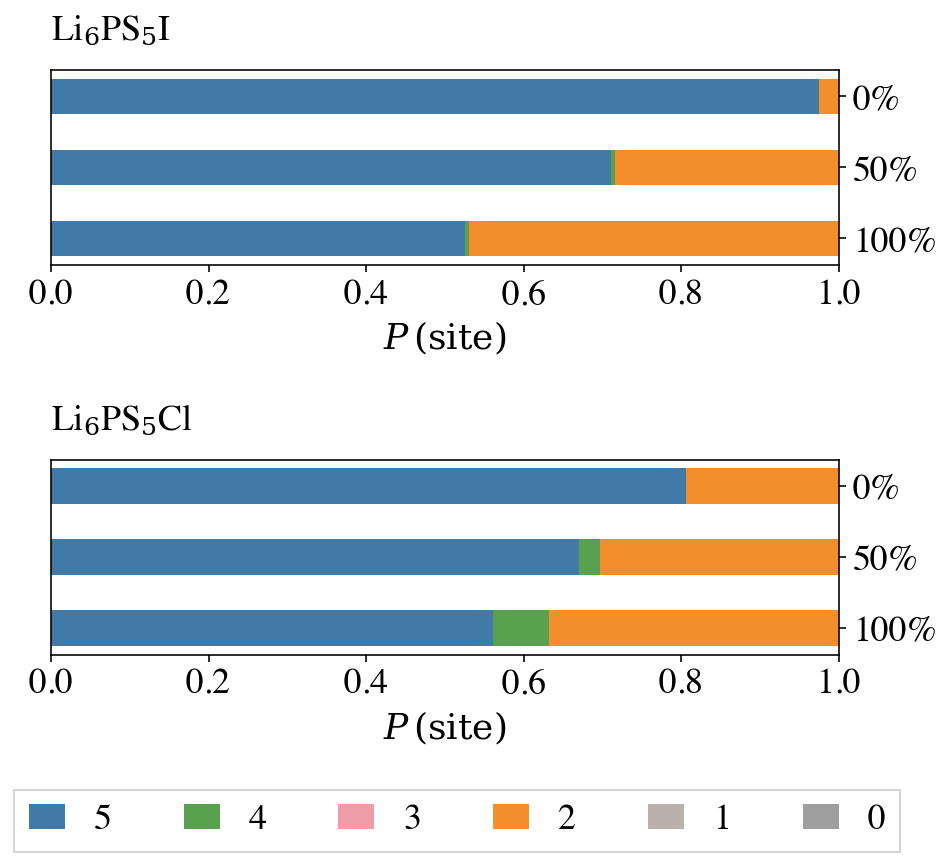

In [10]:
ind = np.arange(3)
fig, ax = plt.subplots(2,1, figsize=(7,7))
title = { 'Li6PS5I': r'Li$_6$PS$_5$I',
          'Li6PS5Cl': r'Li$_6$PS$_5$Cl'}

color = {'5': '#4179a7',
         '2': '#f28e2b',
         '4': '#59a14f',
         '3': '#ef9da7', 
         '1': '#bab0ac',
         '0': '#9f9f9f'}

for j, system in enumerate(['Li6PS5I', 'Li6PS5Cl']):
    bottom = np.zeros(3)
    for i in range(5,-1,-1):
        heights = [ populations[system]['0p'][str(i)],
                    populations[system]['50p'][str(i)],
                    populations[system]['100p'][str(i)] ]

        heights.reverse()

        width=0.5
        ax[j].barh(ind, heights, width, left=bottom, label=f'{i}', color=color[str(i)])
        bottom += heights
    ax[j].set_xlabel(r'$P\,(\mathrm{site})$')
    ax[j].set_yticklabels(['100%', '50%', '0%'])
    ax[j].set_yticks([0,1,2])
    ax[j].yaxis.tick_right()
    ax[j].set_title(title[system], pad=15, loc='left', fontsize=18)
ax[1].legend(bbox_to_anchor=(1.1,-0.6), ncol=6, handlelength=1, fancybox=False)
plt.tight_layout()
plt.savefig('../../figures/tetrahedral_site_populations.pdf', bbox_inches='tight')
plt.show()

In [11]:
populations['Li6PS5Cl']['0p']

{'0': 0.0,
 '1': 8.184523809523809e-05,
 '2': 0.19406994047619047,
 '3': 0.0,
 '4': 7.4404761904761905e-06,
 '5': 0.8058407738095238}

In [ ]:
system = 'Li6PS5I'
disorder = '0p'
x_spec = 'I'
xdatcar = Xdatcar(f'{directory}/{system}/{disorder}/run1/inherent_XDATCAR.gz')
analysis = tetrahedral_site_analysis( xdatcar, x_spec )
populations[system][disorder] = site_populations( analysis )